# A Complete Tutorial on Ridge and Lasso Regression in Python

## 1. Brief Overview

Ridge and Lasso regression are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. Here ‘large’ can typically mean either of two things:

Large enough to enhance the tendency of a model to overfit (as low as 10 variables might cause overfitting)
Large enough to cause computational challenges. With modern systems, this situation might arise in case of millions or billions of features
Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and practical use cases differ substantially. If you’ve heard of them before, you must know that they work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. These are called ‘regularization’ techniques. The key difference is in how they assign penalty to the coefficients:

1. Ridge Regression:
    * Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
    * Minimization objective = LS Obj + α * (sum of square of coefficients)
2. Lasso Regression:
    * Performs L1 regularization, i.e. adds penalty equivalent to absolute value of the magnitude of coefficients
    * Minimization objective = LS Obj + α * (sum of absolute value of coefficients)
    
Note that here ‘LS Obj’ refers to ‘least squares objective’, i.e. the linear regression objective without regularization.

If terms like ‘penalty’ and ‘regularization’ seem very unfamiliar to you, don’t worry we’ll talk about these in more detail through the course of this article. Before digging further into how they work, lets try to get some intuition into why penalizing the magnitude of coefficients should work in the first place.

##  2. Why penalize the Magnitude of Coefficients?

Lets try to understand the impact of model complexity on the magnitude of coefficients. As an example, I have simulated a sine curve (between 60° and 300°) and added some random noise using the following code:


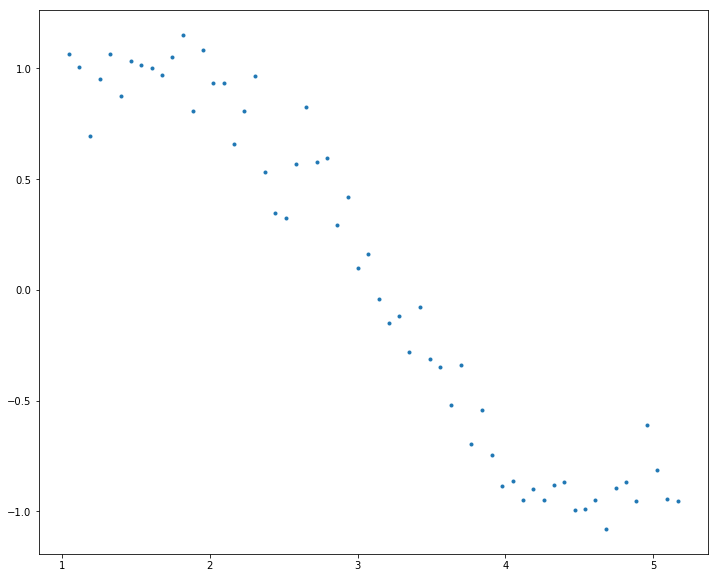

In [4]:
# Importing libraries. The same will be used throughout the article

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

# define input array with angles from 60deg to 300 deg converted to radians
x = np.array([i*np.pi/180 for i in range(60, 300, 4)])
np.random.seed(10)  # setting seed for reproducability
y = np.sin(x)+np.random.normal(0,0.15,len(x))

data = pd.DataFrame(np.column_stack([x,y]), columns=['x','y'])
plt.plot(data['x'], data['y'], '.')

This resembles a sine curve but not exactly because of the noise. We’ll use this as an example to test different scenarios in this article. Lets try to estimate the sine function using polynomial regression with powers of x form 1 to 15. Lets add a column for each power upto 15 in our dataframe. This can be accomplished using the following code:

In [6]:
for i in range(2,16): # power of 1 is already there
    colname = 'x_%d'%i
    data[colname] = data['x']**i
    
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x_7       x_8        x_9       x_10       x_11       x_12       x_13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x_14       x_15  
0   1.907219   1.997235  
1   4.707635   5

Now that we have all the 15 powers, lets make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set. The python code defining the function is:

In [7]:
# Import Linear Regression model from scikit-learn
from sklearn.linear_model import LinearRegression

def linear_regression(data, power, models_to_plot):
    # initialize predictors
    predictors = ['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    # fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors], data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. Consider the following code:

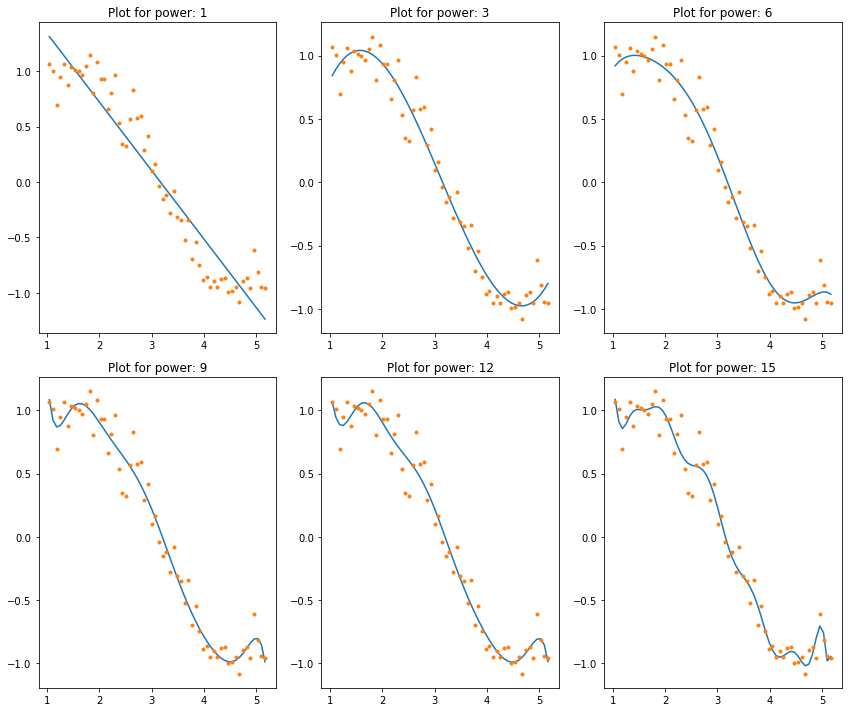

In [8]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this leads to overfitting, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients. This can be analysed by looking at the data frame created above.

In [9]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


It is clearly evident that the __size of coefficients increase exponentially with increase in model complexity__.

## 3. Ridge Regression

As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

**Objective = RSS + α * (sum of square of coefficients)**

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

* α = 0:
    * The objective becomes same as simple linear regression.
    * We’ll get the same coefficients as simple linear regression.
* α = ∞:
    * The coefficients will be zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.
* 0 < α < ∞:
    * The magnitude of α will decide the weightage given to different parts of objective.
    * The coefficients will be somewhere between 0 and ones for simple linear regression.

In [10]:
from sklearn.linear_model import Ridge

def ridge_regression(data, predictors, alpha, models_to_plots={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization. Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. These values have been chosen so that we can easily analyze the trend with change in values of α. These would however differ from case to case.

Note that each of these 10 models will contain all the 15 variables and only the value of alpha would differ. This is different from the simple linear regression case where each model had a subset of features.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.790479636943584e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


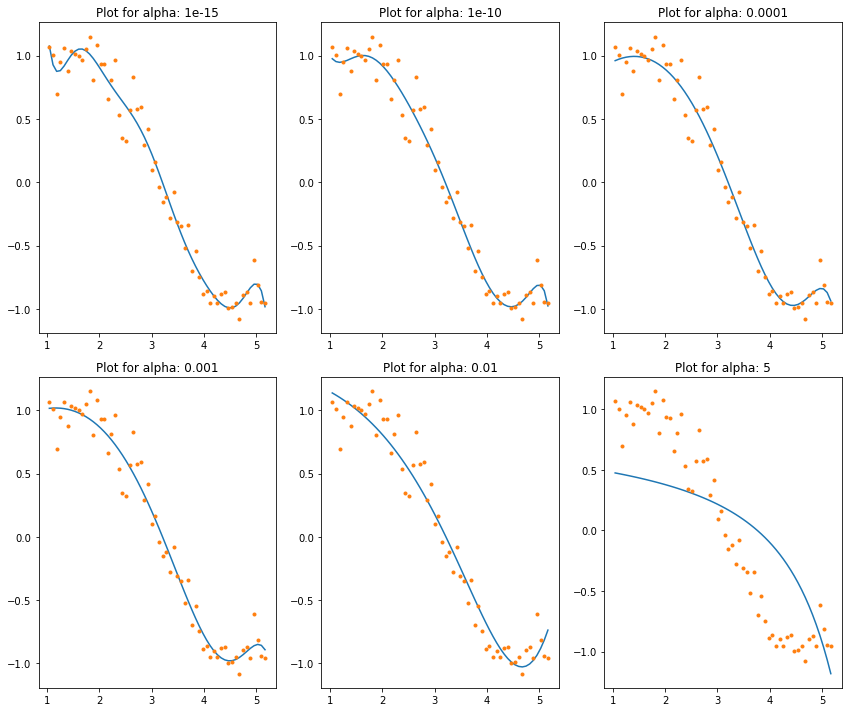

In [11]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Here we can clearly observe that __as the value of alpha increases, the model complexity reduces__. Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.

Lets have a look at the value of coefficients in the above models:

In [12]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,94,-3e+02,3.7e+02,-2.3e+02,60,3.1,-5.3,0.66,0.17,-0.033,-0.0047,0.00096,0.00016,-4.5e-05,3e-06,-3.6e-08
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13


## 4. Lasso Regression

LASSO stands for Least Absolute Shrinkage and Selection Operator. I know it doesn’t give much of an idea but there are 2 key words here – ‘absolute‘ and ‘selection‘.

Lets consider the former first and worry about the latter later.

Lasso regression performs **L1 regularization**, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

**Objective = RSS + α * (sum of absolute value of coefficients)**

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

1. α = 0: Same coefficients as simple linear regression
2. α = ∞: All coefficients zero (same logic as before)
3. 0 < α < ∞: coefficients between 0 and that of simple linear regression

Yes its _appearing to be very similar to Ridge till now_. But just hang on with me and you’ll know the difference by the time we finish. Like before, lets run lasso regression on the same problem as above. First we’ll define a generic function:

In [14]:
from sklearn.linear_model import Lasso

def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Notice the additional parameters defined in Lasso function – ‘max_iter‘. This is the maximum number of iterations for which we want the model to run if it doesn’t converge before. This exists for Ridge as as well but setting this to a higher than default value was required in this case. Why? I’ll come to this in next section, just keep it in the back of the envelope.

Lets check the output for 10 different values of alpha using the following code:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


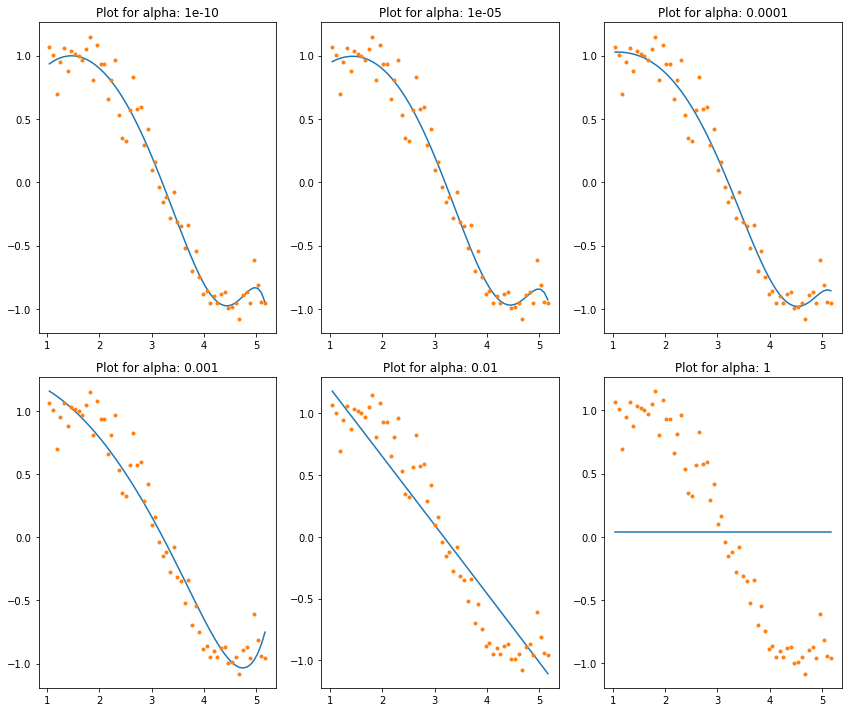

In [15]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

This again tells us that the model complexity decreases with increase in the values of alpha. But notice the straight line at alpha=1. Appears a bit strange to me. Let’s explore this further by looking at the coefficients:

In [18]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.96,0.22,1.1,-0.37,0.00089,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-10,0.96,0.22,1.1,-0.37,0.00088,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-08,0.96,0.22,1.1,-0.37,0.00077,0.0016,-0.00011,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.3e-09,2e-10,-1.9e-10,-9.3e-11
alpha_1e-05,0.96,0.5,0.6,-0.13,-0.038,-0,0,0,0,7.7e-06,1e-06,7.7e-08,0,0,0,-0,-7e-11
alpha_0.0001,1,0.9,0.17,-0,-0.048,-0,-0,0,0,9.5e-06,5.1e-07,0,0,0,-0,-0,-4.4e-11
alpha_0.001,1.7,1.3,-0,-0.13,-0,-0,-0,0,0,0,0,0,1.5e-08,7.5e-10,0,0,0
alpha_0.01,3.6,1.8,-0.55,-0.00056,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0
alpha_1,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


Apart from the expected inference of higher RSS for higher alphas, we can see the following:

1. For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).
2. For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero even for very small values of alpha

Inferences #1,2 might not generalize always but will hold for many cases. The real difference from ridge is coming out in the last inference. Lets check the number of coefficients which are zero in each model using following code:

In [19]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

## 5. Sneak Peak into Statistics (Optional)

As promised, I’ll keep it to a bird’s eye view. If you wish to get into the details, I recommend taking a good statistics textbook. One of my favorites is the [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). The best part about this is that it has been made available for free by the authors.

Let’s start by reviewing the basic structure of data in a regression problem.